In [1]:
import ray
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.metrics import log_loss

In [92]:
def load_fingerprints(fname: str) -> pd.DataFrame:
    return pd.read_csv(fname, index_col=0, header=None)

In [3]:
def load_drugs_and_targets(fname: str) -> dict[str, set]:
    with open(fname, "r") as f:
        lines = f.readlines()
        
    drug_targest = {}
    for line in lines:
        line = line.split()
        drug, targets = line[0][:-1], line[1:]
        
        drug_targest[drug] = set(targets)
    return drug_targest

In [4]:
def transpose(itemsets: dict[str, set]) -> dict[str, set]:
    itemsetsT = {}
    for key, items in itemsets.items():
        for item in items:
            itemsetsT.setdefault(item, set()).add(key)
    return itemsetsT

In [5]:
def jaccard_similarity(a,b):
    common = ( (a==1) & (b==1)).sum()
    total = ( (a==1) | (b==1)).sum()
    return common/total

In [6]:
def plot_graph(G, show_labels=False, node_size=10, figsize=(6,6)):
    f, ax = plt.subplots(1,1, figsize=figsize)
    display = display = nx.spring_layout(G)
    
    nx.draw_networkx_nodes(G, nodelist=G.nodes, pos=display, node_size = node_size, ax=ax, alpha=0.3)
    
    if show_labels==True:
        nx.draw_networkx_labels(G, pos=display, ax=ax)
    
    nx.draw_networkx_edges(G, pos=display, edgelist=G.edges, ax=ax, arrows=False)

In [7]:
def build_graph_from_dict(item_sets):
    items, sets = item_sets.keys(), item_sets.values()
    items = list(items)
    sets = list(sets)

    N = len(items)
    graph = np.zeros((N,N))
    
    for i, s in enumerate(sets):    
        for j in range(i+1, N):
            link_weight = len( s&sets[j] )
            if link_weight!=0:
                graph[i,j]+=link_weight

    return graph+graph.T, dict(enumerate(items))

In [8]:
def probability(x):
    """
    calculates probability according to bigCLAM definition
    Parameters:
        :x: Numpy Array | Number
    """
    return 1 - np.exp(-x)

In [10]:
def random_matrix(shape, min_=0, max_=1):
    """
    Generates a random matrix with values in the range [ {min_}, {max_} ]
    Parameters:
        :shape: --> Tuple or Int indicating the shape of the matrix/Vector
        :min_:  --> Lower Value to be generated in the matrix
        :max_:  --> Highest Value to be generated in the matrix
    """
    return np.random.uniform(low=min_, high=max_, size=shape)

In [11]:
def log_likelihood(fu, f_sum, fv_conns):
    """
    Calculates the log likelihood of a Node representation, given it's neighbours latent vectors, 
        according to bigCLAM algorithm.
    This implementation uses the 'speed up' in which it is assumed that each node only connects
        to a few of the existing nodes. This speedup pre-computes the sum of the F matrix
        and uses information regarding the neighbours instead of the non-neighbours, which results
        in a smaller set of data to process.
    Parameters:
        :fu:       --> Latent Vector of node U
        :f_sum:    --> Sum of Latent Matrix over the community axis
        :fv_conns: --> Latent Vectos of node U neighbors
    """
    prob_conns = probability( fu@fv_conns.T)
    conns_sum = np.log(prob_conns).sum()
    
    fv_nconns = f_sum - fu - fv_conns.sum(axis=0)
    nconns_sum = (fu * fv_nconns).sum()
    return conns_sum - nconns_sum

In [12]:
@ray.remote
def big_clam_ray(
    F_shape,       # shape of the Latent Matrix, NxK : N-Number of nodes & K-Number of communities  
    conns,         # Dictionary containing the neighborhoods of each node 
    true_graph,    # Adjacency Matrix
    hold_out_idx,  # List of indexes regarding the hold 
    LR,            # Learning Rate
    n_iters,       # Number of iterations
    α,             # Minimum Latent value for any community, to avoid gradient explosion
    MAX_VALUE,     # Maximum Latent value
    stop_threshold  # Minimum percentage improvement treshold for early stopping
):
    """
    Computes bigClam for K communities (Number of columns in F_shape)
    """
    N,K = F_shape
    #initialize F
    F = random_matrix(F_shape)
    nodes = np.arange(N, dtype=int)
    counter=0
    
    f_sum=F.sum(axis=0)
    previous_ll = init_ll = np.array([
        -log_likelihood(F[u], f_sum, F[conns[u]]) for u in nodes
    ]).sum()

    for i in range(n_iters): 
        f_sum = F.sum(axis=0)
        #randomize epoch order
        np.random.shuffle(nodes)
        current_ll = 0
        
        for u in nodes:
            fv_conns = F[conns[u]]
            #F vector of node u
            fu = F[u]

            #connection probablity of fu to each fv
            scores=fu@fv_conns.T
            prob_con = probability(scores)

            fraction = (1 - prob_con)/prob_con
            conns_factor = (fv_conns.T @ fraction)

            #optimization of non-connection neighbours sum
            nconns_factor = f_sum - fu - fv_conns.sum(axis=0)

            # calculate gradient
            u_grad = conns_factor - nconns_factor
            u_grad = LR * u_grad
            
            #update the community likelihoods for each node
            F[u] += u_grad
            clip_idx = F[u] < α
            F[u, clip_idx] = α
            
            current_ll += log_likelihood(F[u], f_sum, F[conns[u]])
            
        if i%2000 == 0:
            print(f"{K} communities -- iteration {i} finished...")
        
        #check if improvement below 0.001% of previous value, for early stopping
        if np.abs(previous_ll - current_ll) < stop_threshold * np.abs(previous_ll):
            counter+=1
            if counter==5:
                print(f"{K} communities -- Early Stop at iteration {i}...")
                break
        else:
            counter=0
        previous_ll = current_ll
    
    print(f"{K} communities -- Finishing...")
    
    f_sum = F.sum(axis=0)
    final_ll=np.array(
        [-log_likelihood(F[u], f_sum, F[conns[u]]) for u in range(N)]
    ).sum()
    
    predicted_graph = np.round(
        get_graph_from_communities(F), 
        3
    )
    
    hold_out_ll = log_loss(
        true_graph[hold_out_idx], 
        predicted_graph[hold_out_idx], 
        labels=(0,1)
    )
    
    graph_ll = log_loss(
        true_graph.flatten(), 
        predicted_graph.flatten(),
        labels=(0,1)
    )
    return init_ll, final_ll, hold_out_ll, graph_ll

In [13]:
def run_bigClam(N, K_values, connections, true_graph, mask, 
                n_iters=10000, LR=0.00001, max_F=None, α=1e-4,
                stop_threshold=0.001):
    """
    Computes bigCLAM for different number of communities in parallel using ray.
    Returns scores for each model, for comparison.
    
    :Parameters:
        :N:           --> Number of nodes
        :K_values:    --> iterable with the different number of communities to test
        :connections: --> lookup table mapping each node to an iterable with the node connections
        :true_graph:  --> adjacency matrix of the graph
        :mask:        --> binary matrix with 0 in the node positions of the hold_out_set and 1 in the other positions
        :n_iters:     --> number of epochs to estimate the latent matrix
        :LR:          --> learning rate of the model. common values like 0.01 tend to diverge and cause overflows
        :max_F:       --> Max value allowed in the latent matrix
        :α:           --> minimum likelihood considered for a node to belong to a community, to avoid the 0 likelihood
    """
    unmask = (mask+1)%2
    hold_out_idx = np.where(unmask==1)
    
    columns = [
        "initial_log_likelihood", 
        "final_log_likelihood", 
        "hold_edges_log_loss", 
        "adjacency_graph_log_loss"
    ]
    
    results = pd.DataFrame(
        columns = columns
    )
    
    ray_res = []
    for K in K_values:        
        ray_res.append(
            big_clam_ray.remote(
                (N,K),
                conns,  
                true_graph, 
                hold_out_idx, 
                LR=LR, 
                n_iters=n_iters, 
                α=α, 
                MAX_VALUE=max_F,
                stop_threshold=stop_threshold)
        )
    ray_res = ray.get(ray_res)
        
        
    for K, res in zip(K_values, ray_res):        
        results.loc[K] = dict(zip(columns, res))

    return results

In [14]:
def big_clam(conns, F, LR=0.00001, n_iters=1000, α = 1e-8, MAX_VALUE=None, stop_treshold=0.001):
    """BigCLAM algorithm"""
    N,K = F.shape
    nodes = np.arange(N, dtype=int)
    
    f_sum=F.sum(axis=0)
    previous_ll = np.array([
        -log_likelihood(F[u], f_sum, F[conns[u]]) for u in nodes
    ]).sum()
    counter = 0
    
    for i in tqdm(range(n_iters)): 
        f_sum = F.sum(axis=0)
        #randomize epoch order
        np.random.shuffle(nodes)
        current_ll=0
        
        for u in nodes:
            fv_conns = F[conns[u]]
            #F vector of node u
            fu = F[u]

            #connection probablity of fu to each fv
            scores=fu@fv_conns.T
            prob_con = probability(scores)

            fraction = (1 - prob_con)/prob_con
            conns_factor = (fv_conns.T @ fraction)

            #optimization of non-connection neighbours sum
            nconns_factor = f_sum - fu - fv_conns.sum(axis=0)

            # calculate gradient
            u_grad = conns_factor - nconns_factor
            u_grad = LR * u_grad
                        
            #update the community likelihoods for each node
            F[u] += u_grad
            clip_idx = F[u] < α
            F[u, clip_idx] = α
            
            current_ll += log_likelihood(F[u], f_sum, F[conns[u]])
        
        if np.abs(previous_ll - current_ll) < stop_treshold * np.abs(previous_ll):
            counter+=1
            if counter==5:
                print("Early Stop")
                break
        else:
            counter=0
        previous_ll = current_ll
            
    f_sum = F.sum(axis=0)
    final_ll=np.array(
        [-log_likelihood(F[u], f_sum, F[conns[u]]) for u in range(N)]
    ).sum()
    return final_ll

In [15]:
def get_communities(F, thresh: float) -> dict:
    """Given F, assigns a node to a community if Fuc value is above the treshold value {thresh}"""
    NN, k = F.shape
    
    comunities = {}
    for c in range(k):
        locs = np.where(F[:, c]>=thresh)[0]
        comunities[c] = set(list(locs))
    return comunities

In [16]:
def get_graph_from_communities(F):
    """
    Given F, creates a weighted adjacency graph where each edge (a,b) is the probability of 
    node a being connected with node b.
    """
    N, k = F.shape
    graph = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            if i!=j:
                graph[i,j] = probability(F[i]@F[j])
    
    return graph

In [63]:
def get_top_k_targets(community_nodes, k=5):
    """
    Returns the {k} targets most frequent in a certain community, and the corresponding frequencies
    """
    target_counts = {}
    for node in community_nodes:
        drug_id = node2drug[node]
        for target in drugs[drug_id]:
            target_counts[target] = target_counts.get(target, 0) + 1
            
    return dict(sorted(target_counts.items(), key=lambda x: x[1], reverse=True)[:k])

## Data loading 
- Load the drug-target dataset
- Create the drug-drug graph where edges represent common targets between two nodes

In [17]:
drugs = load_drugs_and_targets("acts.txt")
n_drugs = len(drugs)
n_targets = len(transpose(drugs))
print("number of nodes: ", n_drugs)
print("number of targets: ", n_targets)

number of nodes:  1101
number of targets:  1244


In [64]:
drugs_graph, node2drug = build_graph_from_dict(drugs)
unweigthed_graph = (drugs_graph>0)*1

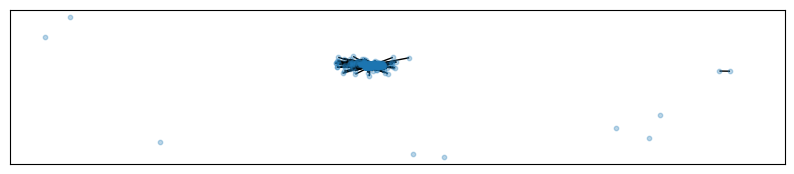

In [95]:
G = nx.Graph()
G.add_nodes_from(range(n_drugs))
G.add_edges_from( np.argwhere(drugs_graph!=0) )
plot_graph(G, figsize=(10,2))

It can be seen that this graph as a very dense structure.
Some nodes are not connected to that dense area, and a few do not have edges at all.
It is likely that no information can be extracted from those edges, as they are "outliers" with no common information to the other nodes.

## Big Clam
- To selected the number of communities, 20% of the edges will be removed from the graph, and a few K values will be tested. The model that obtains better performance in predicting these edges will be the one selected for further analysis. For this, the following tasks will be performed:
    1. Create and hold out set of $20\%$ of the **edges**.
    2. Evaluate each model capability of rebuilding the hold out edges, by calculating the log loss of the hold out edges.
    3. Evaluate each model capability of rebuilding the whole graph, by calculating the log loss of the whole predicted graph (This step is to avoid a model that would just connected every node and therefore would have a good score in the hold out set).
- Generate the F matrix with the selected number of communities using the true graph.
- Create a weighted graph, given F, where each edge weight corresponds to the connection likelihood.
- Analyze and comment "suggested" node connections aswell as their 'fingerprints'.

In [77]:
NN = drugs_graph.shape[0]
α = 1e-4 # minimum latent value (avoid 0 because it caused gradient explosion)
δ = np.sqrt(-np.log(1 -  α)) #delta value according to bigClam specification

In [78]:
node_pairs = np.sort(np.argwhere(drugs_graph!=0), axis=1) # contains duplicated edges because (a,b) is the same as (b,a)
node_pairs = set(list(map(tuple, node_pairs))) # remove duplicates by creating a set, since tuples are immutable
node_pairs = np.array(list(node_pairs)) # convert to numpy array for easier operations
node_pairs.shape

(249617, 2)

In [35]:
#select the 20% edges to remove
N_out = int(len( node_pairs ) * 0.2)
node_pairs_idx = np.arange(len(node_pairs), dtype=int)

np.random.seed(1)
hold_out_idx = np.random.choice(node_pairs_idx, size=N_out, replace=False)

mask = np.ones(drugs_graph.shape)
for idx in hold_out_idx:
    i,j = node_pairs[idx]
    mask[i,j]=mask[j,i]=0
unmask=(mask+1)%2

In [36]:
#remove the edges in the graph used for estimating the number of communities
drugs_graph_train = drugs_graph.copy()*mask

In [37]:
(drugs_graph_train>0).sum()//2

199694

In [38]:
#structure with the neighbours of each node
conns = {i : np.where(node_conns!=0)[0] for i, node_conns in enumerate(drugs_graph_train)}

In [26]:
ray.init()

2023-06-08 20:30:26,786	INFO worker.py:1625 -- Started a local Ray instance.


Python version:,3.9.7
Ray version:,2.4.0


In [ ]:
ks = [2<<i for i in range(7, 0, -1)]
bc_results = run_bigClam(
    NN, 
    ks, 
    conns, 
    unweigthed_graph,
    mask=mask,
    n_iters=20000,
    LR=0.00001,
    stop_threshold=0.00001
)

In [28]:
ray.shutdown()

In [39]:
bc_results = pd.read_csv("big_clam_K_results.csv", index_col=0)
bc_results.sort_values("hold_edges_log_loss")

,initial_log_likelihood,final_log_likelihood,hold_edges_log_loss,adjacency_graph_log_loss
64,1.295627e+07,291160.214647,0.373759,0.151944
128,2.599343e+07,281074.947090,0.381138,0.147463
256,5.188450e+07,263732.725416,0.391412,0.137661
32,6.493065e+06,316664.691252,0.398400,0.176056
16,3.290313e+06,324032.103328,0.406824,0.181992
8,1.716282e+06,352798.663877,0.447032,0.212617
4,1.048042e+06,379488.319605,0.482439,0.244551


We can see that the number of communities that the best score was obtained for $64$ communities.

In [31]:
#bc_results.to_csv("big_clam_K_results.csv", index=True)

In [40]:
k=64
F = random_matrix((NN, k))

ll_i=np.array(
    [-log_likelihood(F[u], F.sum(axis=0), F[conns[u]]) for u in range(F.shape[0])]
).sum()
print("Initial Evaluation: ", ll_i)

Initial Evaluation:  12895818.862622857


In [265]:
ll_f = big_clam(conns, F, LR=0.00001, n_iters=15000, α=α, MAX_VALUE=MAX, stop_treshold=0.00001)
print("Final Evaluation: ", ll_f)

  0%|          | 0/15000 [00:00<?, ?it/s]

Early Stop
Final Evaluation:  305047.5576406376


In [41]:
F = np.load("bc_64c.npy")

In [149]:
#np.save("bc_64c.npy", F)

In [42]:
#generate adjacency matrix with weights corresponding to edge probability
#round to three digits to set α to 0
bigClam_graph = np.round(get_graph_from_communities(F), 3)

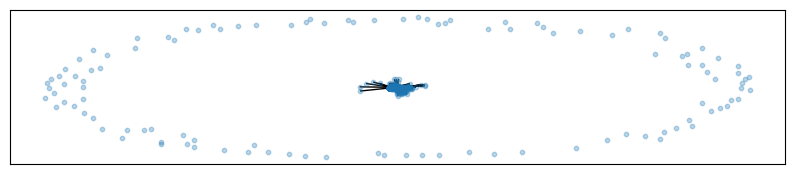

In [96]:
G = nx.Graph()
G.add_nodes_from(range(n_drugs))
G.add_edges_from( np.argwhere((bigClam_graph>0.5)*1!=0) )
plot_graph(G,figsize=(10,2))

In [65]:
new_edges = np.sort(np.argwhere(((bigClam_graph>0.80)*1==1) & (unweigthed_graph==0)), axis=1)
new_edges = set(list(
    map(tuple, new_edges)
))
new_edges

{(63, 183), (143, 793), (233, 567), (233, 580), (233, 1087), (678, 861)}

The list above contains the edges that the model generated with a high probability ($\ge 80\%$) and do not exist in the original graph.

In [62]:
for i, c in get_communities(F, δ).items():
    if 63 in c and 183 in c:
        print(i, end=", ")

2, 21, 28, 47, 55, 

Nodes 63 and 183 ( first sugested edge ) are both part of the following communities: [2, 21, 28, 47, 55] 

In [67]:
support = {}
for d in drugs:
    for t in drugs[d]:
        support[t] = support.get(t,0)+1
most_common = sorted(support.items(), key=lambda x: x[1], reverse=True)[:5]
most_common

[('REP', 530),
 ('SLCO1B1', 337),
 ('SLCO1B3', 336),
 ('LMNA', 244),
 ('CYP3A4', 146)]

In [70]:
c=[0,0,0,0,0]
for i in range(k):
    top_targets = get_top_k_targets(get_communities(F, δ)[i])
    for i, target in enumerate(most_common):
        if target[0] in top_targets:
            c[i]+=1
c

[63, 64, 64, 62, 30]

We can see that the targets with a higher support are very common in all communities, which is logical since "REP", for example is a target of almost 50% of the drugs. These targets will be likely noise for most of the communities, therefore they will be filtered out from the most common targets of each community.

In [73]:
def filter_frequent_targets( community_targets ):
    """helper function to remove 'noisy' targets from the communities"""
    return dict(
        filter(lambda x: x[0] not in dict(most_common), community_targets.items())
    )

We will now analyse the first community in which nodes $63$ and $183$ are part of.

In [82]:
filter_frequent_targets(get_top_k_targets(get_communities(F, δ)[2], 5))

{'TSHR': 79}

In [84]:
support["TSHR"]

79

In [85]:
print(
    "TSHR" in drugs[node2drug[63]], 
    "TSHR" in drugs[node2drug[183]]
)

False True


In [93]:
fp = load_fingerprints("fps.txt").to_numpy()
jaccard_similarity(fp[63], fp[183])

0.1

The fingerprint form the drugs is not very similar, at least with the structure it is represented.

We can see that community 2 contains every node that targets "TSHR".
The model suggested a connection between nodes $63$ and nodes $183$, which could mean that they may share some target.

One of the communities that they are a part of, community $2$, contains all the nodes with the "TSHR", being this one of the most frequent targest in this community. We also saw that the gene "TSHR" is not a target for the drug corresponding to the node $63$ (PDFDA0064) but it is a target for drug corresponding to the node $183$ (PDFDA0184). 

The target "TSHR" could be the one that creates the connection between these two nodes. It would have to be studied. There are 4 more communities that can have information regarding these connection. Maybe there is more than one uncovered shared target. <br>
It might even be that they do not share targets at all, but the results from bigCLAM suggest otherwise.